In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


from xgboost import XGBRegressor

# Housing Prices Competition for Kaggle Learn Users

/kaggle/input/home-data-for-ml-course

## 1. Dataset and EDA

In [2]:
housing_data = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv", index_col = "Id")
housing_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [3]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [4]:
# housing_data.describe().T

In [5]:
housing_data.SalePrice.isna().sum()

0

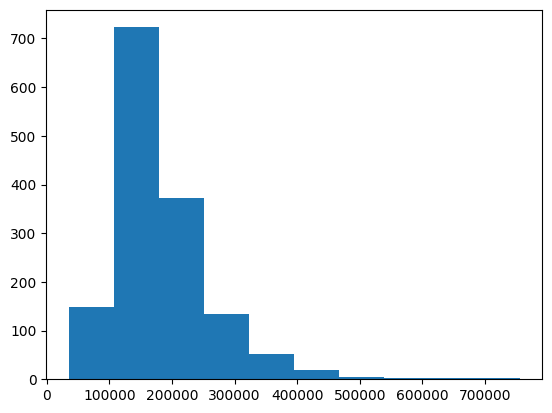

In [6]:
plt.hist(housing_data.SalePrice)
plt.show()

In [7]:
missing_data_by_column = pd.DataFrame({"missing_value_count":housing_data.isna().sum(), "col_dtype": housing_data.dtypes})
missing_data_by_column[missing_data_by_column.missing_value_count > 0]


,missing_value_count,col_dtype
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


#### Columns with too many missing values

In [8]:
columns_to_drop = missing_data_by_column[missing_data_by_column.missing_value_count > 1000].index.tolist()
columns_to_drop

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

#### Garage

In [9]:
garage_column_selector = make_column_selector(pattern = "Garage")

In [10]:
columns_garage = garage_column_selector(housing_data)
columns_garage

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

In [11]:
housing_data.GarageType.value_counts()

GarageType
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

In [12]:
housing_data[housing_data[columns_garage].isna().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
40,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,82000
49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
79,90,RL,72.0,10778,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,136500
89,50,C (all),105.0,8470,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,10,2009,ConLD,Abnorml,85000
90,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,70,RM,50.0,5250,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,122000
1408,20,RL,NaN,8780,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,3,2009,WD,Normal,112000
1450,180,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml,92000


No value for "no garage", missing values are the same 81 entries, therefore assume NaN means garage does not exist. 

In [13]:
# housing_data.select_dtypes("object").nunique()

## 2. Preprocessing

In [14]:
# Remove rows with missing target, separate target from predictors
housing = housing_data.dropna(axis=0, subset=['SalePrice'])
target = housing.SalePrice              
housing = housing.drop(['SalePrice'], axis=1)

In [15]:
# Break off validation set from training data
housing_train, housing_val, target_train, target_val = train_test_split(housing, target, 
                                                                train_size = 0.8, test_size = 0.2,
                                                                random_state = 42)

In [16]:
# Drop low-information columns
columns_to_keep = [col_name for col_name in housing_train.columns if col_name not in columns_to_drop]

In [17]:
# Select numerical columns
numerical_cols = [col_name for col_name in columns_to_keep if housing_train[col_name].dtype in ['int64', 'float64']]

# Select categorical columns 
categorical_cols = [col_name for col_name in columns_to_keep if housing_train[col_name].dtype == "object"]

In [18]:
# Preprocessing for numerical data

numerical_imputer = ColumnTransformer(
    transformers=[
        ('garage', SimpleImputer(strategy = "constant", fill_value = 0), garage_column_selector),
    ], 
    remainder =  KNNImputer(n_neighbors = 3)
)

numerical_transformer = Pipeline(steps=[
    ('imputer', numerical_imputer),
    ('scaler', MinMaxScaler())
])

# Preprocessing for categorical data

categorical_imputer = ColumnTransformer(
    transformers=[
        ('garage', SimpleImputer(strategy = "constant", fill_value = "NoGarage"), garage_column_selector),
    ], 
    remainder =  SimpleImputer(strategy='most_frequent')
)

categorical_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit the preprocessor, so that it could be used to transform eval_set inside grid search
preprocessor.fit(housing_train)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  ColumnTransformer(remainder=KNNImputer(n_neighbors=3),
                                                                    transformers=[('garage',
                                                                                   SimpleImputer(fill_value=0,
                                                                                                 strategy='constant'),
                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x78c2d1d95fc0>)])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'Overal...
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'Neighborhood', 'Condition1',
                                  'Condition2', 'BldgType', 'HouseStyle',
                                  'RoofStyle', 'RoofMatl', 'Exterior1st',
                                  'Exterior2nd', 'MasVnrType', 'ExterQual',
                                  'ExterCond', 'Foundation', 'BsmtQual',
                                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual', ...])])

## 3. Model

In [19]:
# Define a model 
xgb = XGBRegressor(early_stopping_rounds = 10, random_state = 42)

# Define grid search
grid_search = GridSearchCV(xgb, 
                           cv = 5,
                           param_grid = {
                               "n_estimators": [1000],
                               "learning_rate": [0.08, 0.1, 0.2]
                           },
                           scoring = "neg_mean_absolute_error"
                          )

# Perform gridsearch with XGB model and preprocessed data
grid_search.fit(
    preprocessor.transform(housing_train), 
    target_train, 
    eval_set=[(preprocessor.transform(housing_val), target_val)], 
    verbose = False)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.08, 0.1, 0.2],
                         'n_estimators': [1000]},
             scoring='neg_mean_absolute_error')

In [20]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.823791,0.222496,0.003553,0.000372,0.08,1000,"{'learning_rate': 0.08, 'n_estimators': 1000}",-17089.378506,-20712.755876,-18813.572149,-17266.870004,-15559.212145,-17888.357736,1748.300922,2
1,0.805067,0.224075,0.003807,0.000481,0.1,1000,"{'learning_rate': 0.1, 'n_estimators': 1000}",-17283.761251,-20115.231470,-18832.033320,-17505.576532,-15388.858906,-17825.092296,1586.759618,1
2,0.460862,0.163015,0.003218,0.000465,0.2,1000,"{'learning_rate': 0.2, 'n_estimators': 1000}",-17702.890892,-19648.016059,-19337.309462,-17500.932705,-15576.120976,-17953.054019,1463.274780,3


In [21]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

In [22]:
best_model = grid_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
best_model.score(preprocessor.transform(housing_train), target_train)

0.996448269231113

In [24]:
mean_absolute_error(target_val, best_model.predict(preprocessor.transform(housing_val)))

16542.03356431935

17682.454589041095

17560.22116438356

16930.993939961474

16761.052065496577

16542.03356431935


## 4. Submission

In [25]:
# Read test set
housing_test = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv", index_col = "Id")

# Get predictions
predictions_test = best_model.predict(preprocessor.transform(housing_test))

In [26]:
# Subbmission output
output = pd.DataFrame({'Id': housing_test.index,
                       'SalePrice': predictions_test})
output.to_csv('submission.csv', index = False)